# Predictive maintenance with neural networks

<div>
    <br/>
    <img src="https://canlogger1000.csselectronics.com/img/intel/Predictive-Maintenance-4.0-Data-Logger-CANopen.png" width="400"/>
</div>

A major problem faced by businesses in asset-heavy industries such as manufacturing is the significant costs associated with delays in the production process due to mechanical problems. Most of these businesses are interested in predicting these problems in advance so that they can proactively fix these issues before they occur which will reduce the costly impact caused by downtime. 

In this notebook, we will try to predict machine failures in advance. Specifically, our goal is to **compute the probability that a machine will fail in the next 24 hours due to a certain component failure**. 

This notebook is based on the dataset and data preparation provided in: https://gallery.azure.ai/Collection/Predictive-Maintenance-Implementation-Guide-1. If you are interested in understanding how the data was preprocessed, have a look at the notebook provided there. In today's lecture, we are focused more on the modelling part of the problem, particularly using neural networks!

Nowadays, there are many (really a lot!) Python packages that allow to develop and train neural networks: e.g. Tensorflow, Torch, Keras (now actually part of Tensorflow), Theano, etc. Even Sklearn has support for neural networks. Unfortunately, the support in Sklearn is rather limiting. So, instead, we will rely on a very popular Python package that is still high-level and easy to use for the most part (like Sklearn), but much more powerful - Keras. Therefore, if you haven't done so, please install the Python package called "Keras" before you continue with this notebook.

In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras

%matplotlib inline
import matplotlib.pyplot as plt

#matplotlib style options
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 8)
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 8)

# Loading data from the different sources

In order to build our predictive maintenance system, we will consider data from 5 sources:

* **Machine conditions and usage:** The operating conditions of a machine e.g. data collected from sensors.
* **Error history:** The history of error codes from the machine.
* **Maintenance history:** The repair history of a machine, e.g. previous maintenance activities or component replacements.
* **Machine features:** The features of a machine, e.g. engine size, make and model, location.
* **Failure history:** The failure history of a machine or component within the machine.

The raw data from these sources was already pre-processed, and relevant features were extracted from it in order to be used in this notebook. Therefore, all you need to do is to load the 5 datasets and make sure that you understand what features each one contains.

### Machine conditions and usage: telemetry data (voltage, rotation, pressure and vibration)

We begin by loading the CSV file with the telemetry data. It corresponds to sensor data and includes voltage, rotation, pressure and vibration. The raw data was very high-resolution (every 1h) for the problem that we are trying to solve (predict failures 24h in advance). Therefore, for each sensor, features were extracted corresponding to the mean ("mean") and standard deviation ("sd") of the sensor in last 3h, and also in the last 24h window. 

We will load the "telemetry.csv" file using Pandas, convert the "datetime" column to the Python datetime basic format using pd.to_datetime() and print the first rows of the dataset.

In [2]:
# load data from csv
telemetry = pd.read_csv('telemetry.csv')

# format datetime field which comes in as string
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], format="%Y-%m-%d %H:%M:%S")

# show first rows
telemetry.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
0,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,169.733809,445.179865,96.797113,40.385160,15.726970,39.648116,11.904700,5.601191
1,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,170.614862,446.364859,96.849785,39.736826,15.635083,41.828592,11.326412,5.583521
2,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,169.893965,447.009407,97.715600,39.498374,13.995465,40.843882,11.036546,5.561553
3,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,171.243444,444.233563,96.666060,40.229370,13.100364,43.409841,10.972862,6.068674
4,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,170.792486,448.440437,95.766838,40.055214,13.808489,43.742304,10.988704,7.286129


Make sure that you understand what the Pandas dataframe above contains. The column names should be more or less self-explainatory, but if it is not clear, make sure to ask! :-)

We will now make a plot for visualizing the voltage mean ("voltmean_3h") for the machine with ID = 1. Can you do the same for the other machines?

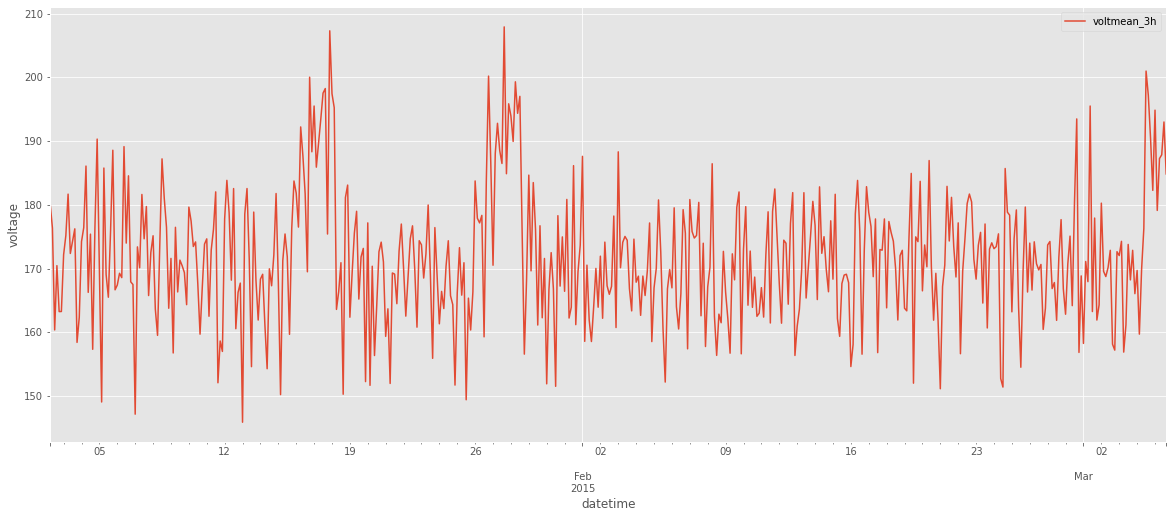

In [3]:
# plot voltage data (3-hour bins)
telemetry[telemetry.machineID == 1][:500].plot(x='datetime', y='voltmean_3h', figsize=(20,8))
plt.ylabel('voltage')
plt.show()

There are some higher spikes in the voltage every once in a while, right? Maybe they correlate with failures...

### Error data

The second major data source is the error logs. These are non-breaking errors thrown while the machine is still operational and do not constitute as failures. Each machine has different components, each of which can fail at any moment. However, before they fail, it is common for a machine to start registering error codes indicating that something may not be well. The file "error_count.csv" includes error counts since the last failure.

Let's load the data and see what it looks like:

In [4]:
# load data from csv
error_count = pd.read_csv('error_count.csv')

# format datetime field which comes in as string
error_count['datetime'] = pd.to_datetime(error_count['datetime'], format="%Y-%m-%d %H:%M:%S")

# show first rows
error_count.head()

,machineID,datetime,error1count,error2count,error3count,error4count,error5count
0,1,2015-01-02 06:00:00,0.0,0.0,0.0,0.0,0.0
1,1,2015-01-02 09:00:00,0.0,0.0,0.0,0.0,0.0
2,1,2015-01-02 12:00:00,0.0,0.0,0.0,0.0,0.0
3,1,2015-01-02 15:00:00,0.0,0.0,0.0,0.0,0.0
4,1,2015-01-02 18:00:00,0.0,0.0,0.0,0.0,0.0


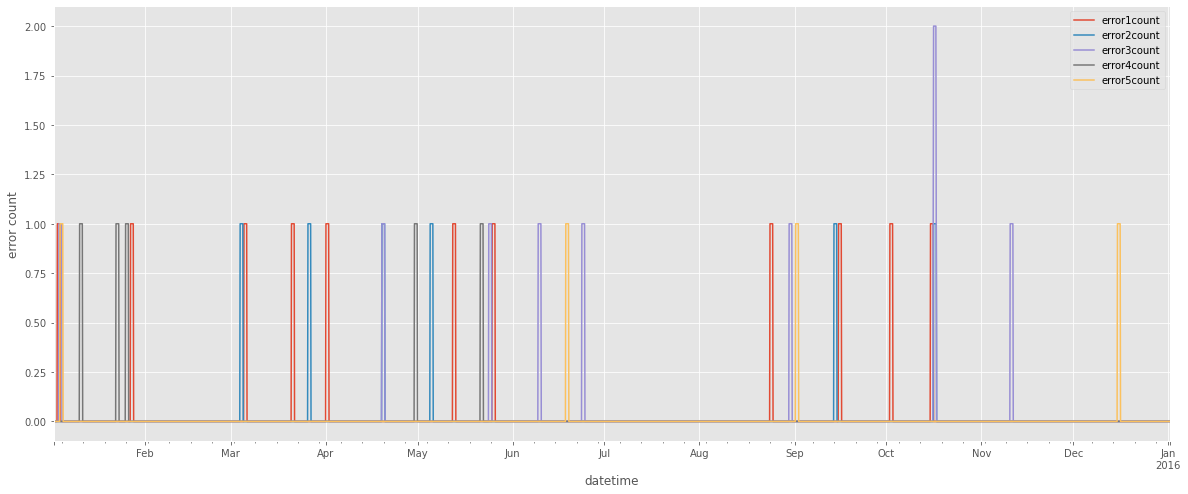

In [5]:
# visualize error count data for one machine
error_count[error_count.machineID == 1].plot(x='datetime', 
                                             y=['error1count','error2count','error3count','error4count','error5count'],
                                             figsize=(20,8))
plt.ylabel('error count')
plt.show()

### Maintenance data

These are the scheduled and unscheduled maintenance records which correspond to both regular inspection of components as well as failures. A record is generated if a component is replaced during the scheduled inspection or replaced due to a breakdown. 

The file "comp_rep.csv" contains features extracted from the raw maintenance log data indicating the elapsed time since each component was replaced. Each machine has 4 components, hence the 4 "comp" columns in this dataset. Let's load it with Pandas and make a plot of the days since last component replacement over time for machineID = 1.

In [6]:
# load data from csv
comp_rep = pd.read_csv('comp_rep.csv')

# format datetime field which comes in as string
comp_rep['datetime'] = pd.to_datetime(comp_rep['datetime'], format="%Y-%m-%d %H:%M:%S")

# show first rows
comp_rep.head()

,datetime,machineID,comp1,comp2,comp3,comp4
0,2015-01-01 06:00:00,1.0,19.000000,214.000000,154.000000,169.000000
1,2015-01-01 07:00:00,1.0,19.041667,214.041667,154.041667,169.041667
2,2015-01-01 08:00:00,1.0,19.083333,214.083333,154.083333,169.083333
3,2015-01-01 09:00:00,1.0,19.125000,214.125000,154.125000,169.125000
4,2015-01-01 10:00:00,1.0,19.166667,214.166667,154.166667,169.166667


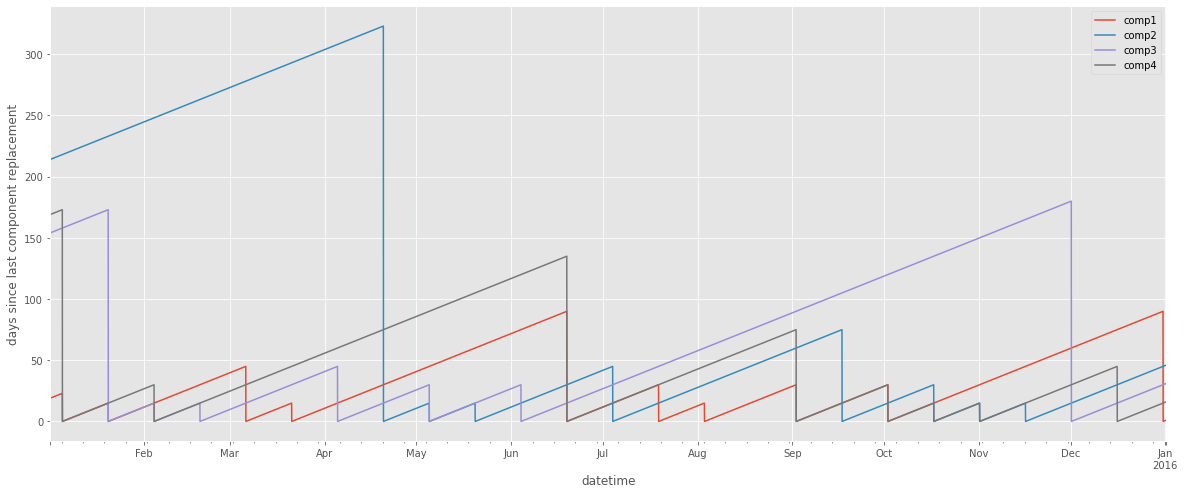

In [7]:
# visualize days since last component replacement
comp_rep[comp_rep.machineID == 1].plot(x='datetime', 
                                             y=['comp1','comp2','comp3','comp4'],
                                             figsize=(20,8))
plt.ylabel('days since last component replacement')
plt.show()

### Machine characteristics

The next dataset ("machines.csv") is rather simple: it contains, for each machine, information about the model and how old it is. Let's see what it looks like:

In [8]:
# load data from csv
machines = pd.read_csv('machines.csv')

# show first rows
machines.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [9]:
# turn "model" variable into dummy variables
machines['model'] = machines['model'].astype('category')
machines = pd.get_dummies(machines)
machines.head()

,machineID,age,model_model1,model_model2,model_model3,model_model4
0,1,18,False,False,True,False
1,2,7,False,False,False,True
2,3,8,False,False,True,False
3,4,7,False,False,True,False
4,5,2,False,False,True,False


### Failure data

Lastly, the most important data source: the failure logs. This is registry of dates and times when each of the components (1-4) failed. 

In [10]:
# load data from csv
failures = pd.read_csv('failures.csv')

# format datetime field which comes in as string
failures['datetime'] = pd.to_datetime(failures['datetime'], format="%Y-%m-%d %H:%M:%S")
#failures['failure'] = failures['failure'].astype('category')

print("Total number of failures: %d" % len(failures.index))
failures.head()

Total number of failures: 761


,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


Let's now make a plot of the distribution of the failures by component. Is it an even distribution? Or is one component much more prone to failures than the others?

failure
comp2    259
comp1    192
comp4    179
comp3    131
Name: count, dtype: int64

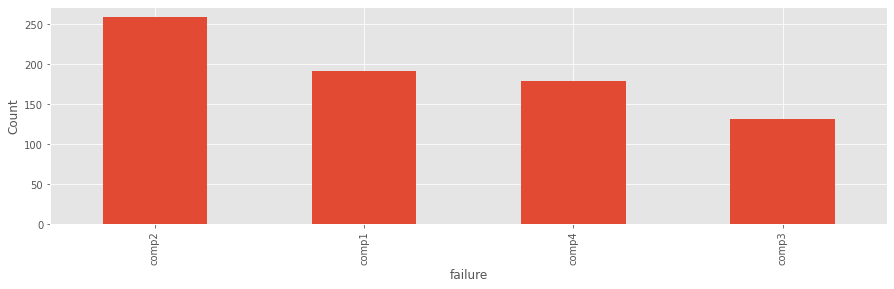

In [11]:
# plot distribution of failures by component
plt.figure(figsize=(15, 4))
failures['failure'].value_counts().plot(kind='bar')
plt.ylabel('Count')
failures['failure'].value_counts()

# Combine different sources of data

Did you notice that dataset from the different sources above have different time scales? Telemetry and error data is provided every 3h, maintenance data is hourly, machine information is time-invariant, and failure data is just a log with the occurrences. In order to combine all these different sources of data and use them to forecast component failures, we need to make sure that we align them properly in the temporal dimension!

In order to do this merging and alignment, we can make use of the "merge" function of Pandas. For the purpose of this notebook, we will adopt a time resolution of 3h. Therefore, we need to be careful with the order in which we perform the "merge" operations, and also the keys that we use to merge ("on" parameter) and the type of join ("how" parameter)! The code below makes the data fusion and alignment at a 3h resolution. Please ensure that it makes sense for you.

Given this data preparation, the prediction problem then corresponds to making predictions every 3h about whether each machine component will fail in the next 24h.

In [12]:
features = telemetry.merge(error_count, on=['datetime', 'machineID'], how='left')
features = features.merge(comp_rep, on=['datetime', 'machineID'], how='left')
features = features.merge(machines, on=['machineID'], how='left')

print(features.head())
features.describe()

   machineID            datetime  voltmean_3h  rotatemean_3h  pressuremean_3h  \
0          1 2015-01-02 06:00:00   180.133784     440.608320        94.137969   
1          1 2015-01-02 09:00:00   176.364293     439.349655       101.553209   
2          1 2015-01-02 12:00:00   160.384568     424.385316        99.598722   
3          1 2015-01-02 15:00:00   170.472461     442.933997       102.380586   
4          1 2015-01-02 18:00:00   163.263806     468.937558       102.726648   

   vibrationmean_3h  voltsd_3h  rotatesd_3h  pressuresd_3h  vibrationsd_3h  \
0         41.551544  21.322735    48.770512       2.135684       10.037208   
1         36.105580  18.952210    51.329636      13.789279        6.737739   
2         36.094637  13.047080    13.702496       9.988609        1.639962   
3         40.483002  16.642354    56.290447       3.305739        8.854145   
4         40.921802  17.424688    38.680380       9.105775        3.060781   

   ...  error5count   comp1    comp2    comp

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,error1count,error2count,error3count,error4count,error5count,comp1,comp2,comp3,comp4,age
count,290601.000000,290601,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,...,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000
mean,50.380935,2015-07-02 22:00:42.478862848,170.774427,446.609386,100.858340,40.383609,13.300173,44.453951,8.885780,4.440575,...,0.027560,0.027058,0.022846,0.019955,0.009780,53.382610,51.256589,52.536687,53.679601,11.345226
min,1.000000,2015-01-02 06:00:00,125.532506,211.811184,72.118639,26.569635,0.025509,0.078991,0.027417,0.015278,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,2015-04-03 00:00:00,164.447794,427.564793,96.239534,38.147458,8.028675,26.906319,5.369959,2.684556,...,0.000000,0.000000,0.000000,0.000000,0.000000,13.250000,12.000000,13.000000,12.875000,7.000000
50%,50.000000,2015-07-02 21:00:00,170.432407,448.380260,100.235357,40.145874,12.495542,41.793798,8.345801,4.173704,...,0.000000,0.000000,0.000000,0.000000,0.000000,32.625000,29.500000,32.125000,32.375000,12.000000
75%,75.000000,2015-10-01 15:00:00,176.610017,468.443933,104.406534,42.226898,17.688520,59.092354,11.789358,5.898512,...,0.000000,0.000000,0.000000,0.000000,0.000000,68.500000,65.875000,67.125000,70.250000,16.000000
max,100.000000,2016-01-01 06:00:00,241.420717,586.682904,162.309656,69.311324,58.444332,179.903039,35.659369,18.305595,...,2.000000,2.000000,2.000000,2.000000,2.000000,491.875000,348.875000,370.875000,394.875000,20.000000
std,28.798424,NaN,9.498824,33.119738,7.411701,3.475512,6.966389,23.214291,4.656364,2.319989,...,0.166026,0.164401,0.151266,0.140998,0.098931,62.478424,59.156008,58.822946,59.658975,5.826345


### Prepare target variables

Now it is time to prepare the target variables, i.e. for each record, is there a failure in the next 24h? This is done by taking a time window prior to the failure of an asset and labelling the feature records that fall into that window as "about to fail due to a problem" while labelling all other records as "no failure". Note that this time window should be picked according to the business case: in some situations it may be enough to predict failures hours in advance, while in others days or weeks may be needed to allow e.g. for arrival of replacement parts.

In [13]:
# main target variable: "failure"
labeled_features = features.merge(failures, on=['datetime', 'machineID'], how='left')
labeled_features = labeled_features.fillna(method='bfill', limit=7) # fill backward up to 24h
labeled_features = labeled_features.fillna('none')
labeled_features.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,comp1,comp2,comp3,comp4,age,model_model1,model_model2,model_model3,model_model4,failure
0,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,...,20.000,215.000,155.000,170.000,18,False,False,True,False,none
1,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,...,20.125,215.125,155.125,170.125,18,False,False,True,False,none
2,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,...,20.250,215.250,155.250,170.250,18,False,False,True,False,none
3,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,...,20.375,215.375,155.375,170.375,18,False,False,True,False,none
4,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,...,20.500,215.500,155.500,170.500,18,False,False,True,False,none


The prediction problem for this example scenerio is to estimate the probability that a machine will fail in the near future due to a failure of a certain component. More specifically, the goal is to compute the probability that a machine will fail in the next 24h due to a certain component failure (component 1, 2, 3, or 4). 

We could approach this problem as multi-class problem, where for each machine at every time-step we predict one of the following classes: "no failure", "failure in comp1", "failure in comp2", "failure in comp3", "failure in comp4". However, doing so entails the assumption that two components cannot fail simultaneously. For example, although related, "failure in comp1" and "failure in comp2" should be treated an independent events, rather then competing events - as you be the case if we treated this as a multi-class problem. Instead, we treat it as multiple binary classification problems. Therefore, we proceed by contructing multiple binary target variables (one per componenent), indicating whether each component will fail in the next 24h:

In [14]:
# convert "failure" target variables into multiple binary targets 
# i.e. one per component indicating failure/no failure
labeled_features['comp1_fail'] = (labeled_features['failure'] == 'comp1').astype(int)
labeled_features['comp2_fail'] = (labeled_features['failure'] == 'comp2').astype(int)
labeled_features['comp3_fail'] = (labeled_features['failure'] == 'comp3').astype(int)
labeled_features['comp4_fail'] = (labeled_features['failure'] == 'comp4').astype(int)
labeled_features.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,age,model_model1,model_model2,model_model3,model_model4,failure,comp1_fail,comp2_fail,comp3_fail,comp4_fail
0,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,...,18,False,False,True,False,none,0,0,0,0
1,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,...,18,False,False,True,False,none,0,0,0,0
2,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,...,18,False,False,True,False,none,0,0,0,0
3,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,...,18,False,False,True,False,none,0,0,0,0
4,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,...,18,False,False,True,False,none,0,0,0,0


# Train/validation/test split

Let us now prepare the features $\textbf{x}$ and target variables y to be used for training, validation and testing. Note the reference to the **validation set**. I.e. besides training and testing, we further split the training set by leaving aside some its data for validation, as shown in the following figure:

<div>
    <br/>
    <img src="http://mlsm.man.dtu.dk/wp-content/uploads/2019/10/val_set.png" width="300"/>
</div>

Why is this important? When using neural networks, besides running the training algorithm, we have quite a few "design" choices to make. This includes things like neural network architecture (e.g. number of hidden layer, number of neurons per layer), activation functions, assessing convergence (e.g. early stopping of training to avoid overfitting), hyper-parameters, optimization algorithm, etc. We cannot simply choose the combination that yields the best results on the testset, because in doing so we risk choosing a combination that happens to work well on that particular testset (for some particular reason or by chance...), but might not be the best combination in general. In other words, we risk biasing our results, thus making them over-optimistic. We therefore need to distance ourselves from the testset, and only use it for the final evaluation of the performance. All other choices need to be made based on the validation set.

To make things easier, we will start by just considering one of the components: component 1. The target variables will then be whether or not component 1 will fail in the next 24h. For this purpose, we will use the following set of features:

In [15]:
features_to_use = ['voltmean_3h', 'rotatemean_3h', 'pressuremean_3h', 'vibrationmean_3h', # telemetry features (3h)
                   'voltsd_3h', 'rotatesd_3h', 'pressuresd_3h', 'vibrationsd_3h', 
                   'voltmean_24h', 'rotatemean_24h', 'pressuremean_24h', 'vibrationmean_24h', # telemetry feat (24h)
                   'voltsd_24h', 'rotatesd_24h', 'pressuresd_24h', 'vibrationsd_24h', 
                   'error1count', 'error2count', 'error3count', 'error4count', 'error5count', # errors over last 24h
                   'comp1', 'comp2', 'comp3', 'comp4', # days since last component replacement
                   'model_model1', 'model_model2', 'model_model3', 'model_model4', 'age'] # machine characteristics

target_variables = 'comp1_fail' # whether or not component 1 will fail in the next 24h

It is now time to split our dataset in training, validation and test sets. We will use for training all the data until 2015-05-31 01:00:00. Data between 2015-06-01 01:00:00 and 2015-07-31 01:00:00 will be used for validation. And data after 2015-08-01 01:00:00 for testing. 

Let's now prepare the data according to this split

In [16]:
# define cutoff between trainset and testset
trainset_end = pd.to_datetime('2015-05-31 01:00:00')
validationset_start = pd.to_datetime('2015-06-01 01:00:00')
validationset_end = pd.to_datetime('2015-07-31 01:00:00')
testset_start = pd.to_datetime('2015-08-01 01:00:00')

# train/val/test split
X_train = labeled_features.loc[labeled_features['datetime'] < trainset_end, features_to_use]
y_train = labeled_features.loc[labeled_features['datetime'] < trainset_end, target_variables]
X_val = labeled_features.loc[((labeled_features['datetime'] > validationset_start) & (labeled_features['datetime'] < validationset_end)), features_to_use]
y_val = labeled_features.loc[((labeled_features['datetime'] > validationset_start) & (labeled_features['datetime'] < validationset_end)), target_variables]
X_test = labeled_features.loc[labeled_features['datetime'] > testset_start, features_to_use]
y_test = labeled_features.loc[labeled_features['datetime'] > testset_start, target_variables]

In [17]:
print("Num train examples:", len(y_train))
print("Num validation examples:", len(y_val))
print("Num test examples:", len(y_test))

Num train examples: 119117
Num validation examples: 48005
Num test examples: 121920


Lets not forget to **standardize our data**! In general, standardizing your data for machine learning algorithms is always recommended!

In [18]:
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)
X_train = (X_train - X_mean) / X_std
X_val = (X_val - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

# Baseline model: Logistic regression

It is always a good idea to start by setting up a baseline. Since we are considering neural networks, and obvious choice for baseline is a logistic regression model. Note that logistic regression corresponds to a neural network with no hidden layers (just input and output layers).

**An important note about model evaluation:**

But before we do that, let us create a function that evaluates the performance of the different classifiers by computing various classification error metrics. In predictive maintenance, machine failures are usually rare occurrences in the lifetime of the assets compared to normal operation. This causes an imbalance in the label distribution which usually causes poor performance as algorithms tend to classify majority class examples better at the expense of minority class examples as the total misclassification error is much improved when majority class is labeled correctly. This makes accuracy a terrible indicator of performance in this particular problem. Since the dataset is so unbalanced (99% of the observations correponds to non-failures), it is easy to get 99% accuracy simply by predicting "no failure" all the time. Therefore, we must rely on other (more robust) metrics such as precision, recall and F1-score (https://en.wikipedia.org/wiki/F1_score).

Make sure that you understand the following code:

In [19]:
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score

# function to evaluate predictions
def evaluate(y_true, y_pred):
    # calculate and display confusion matrix
    labels = np.unique(y_true)
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    print('Confusion matrix\n- x-axis is true labels (none, comp1, etc.)\n- y-axis is predicted labels')
    print(cm)

    # calculate precision, recall, and F1 score
    accuracy = float(np.trace(cm)) / np.sum(cm)
    precision = precision_score(y_true, y_pred, average=None, labels=labels)[1]
    recall = recall_score(y_true, y_pred, average=None, labels=labels)[1]
    f1 = 2 * precision * recall / (precision + recall)
    print("accuracy:", accuracy)
    print("precision:", precision)
    print("recall:", recall)
    print("f1 score:", f1)

Now it is time to fit the logistic regression classifier. For this we will be using Sklearn:

In [20]:
from sklearn.linear_model import LogisticRegression

# estimate model on trainset
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

LogisticRegression(random_state=42)

Can you make predictions for the test set and evaluate their quality using the "evaluate" function defined above?

In [21]:
# make predictions for testset
y_pred = model.predict(X_test)

# evaluate predictions
evaluate(y_test, y_pred)

Confusion matrix
- x-axis is true labels (none, comp1, etc.)
- y-axis is predicted labels
[[121292     86]
 [    94    448]]
accuracy: 0.9985236220472441
precision: 0.8389513108614233
recall: 0.8265682656826568
f1 score: 0.8327137546468402


What do you think of the results? Not too bad, right? 

# Neural networks in Keras

<div>
    <br/>
    <img src="http://mlsm.man.dtu.dk/wp-content/uploads/2019/10/nn_2layer-1.png" width="400"/>
</div>

It is now time to try out a neural network classifier using Keras. Bulding a multi-layer neural network in Keras is fairly easy. We start by creating an object of the class "Sequential" (indicating that the neural network consists of sequence of layers):

```python
model = Sequential()
```

Now we can add layers to our neural network model. For this entire lecture, we will only consider fully connected (dense) layers. Other types exist, but are out of the scope.

```python
model.add(Dense(50, input_dim=30, activation='relu'))
```

The code above adds a new layer to the model with 50 neurons with a ReLU activations function. Since this is the first layer, we also need to tell Keras the dimension of the input (in this case our x's are 30-dimensional - we have 30 features in our dataset). We can now add more hidden layers, or add the final Dense layer. Note that since this is a binary classification problem, the last layer (output layer) must necessarily have only 1 neuron with a sigmoid activation:

```python
model.add(Dense(1, activation='sigmoid'))
```

We can also add Dropout (with a given rate) between the layers using:

```python
model.add(Dropout(rate=0.5))
```

Once the neural network is fully specified, we need to compile it and tell Keras what loss function to use (in the case of binary classification, the loss should be "binary_crossentropy" - see lecture slides), which optimizer to use (Keras has many, but "adam" is a very popular one; it uses an adaptive step size and generally performs very well), and what metrics that can be used to evaluate performance during training. 

```python
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
```

Once compiled, we can train the neural network model using the function "fit":

```python
model.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_val,y_val))
```

Note that we also specified the number of epochs (i.e. how many passes through the dataset), the batch_size (i.e. size of the batch of observations that is used to compute gradients in each gradient step during the optimization of the loss function), and the validation data (so that we can know how validation accuracy evolves over time during training).

Once trained, we can make predictions for new data using the method "predict":

```python
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int) # convert output of sigmoid to binary variable (0 or 1)
```

Note that the second line is necessary in order to convert the output of the sigmoid function in the last layer of the neural network to a binary variable (0 or 1).

And that's all! Not that very complicated, is it? Can you try to do it yourself for the predictive maintenance dataset? See if you can come up with a good neural network architecture that outperforms the logistic regression classifier, and try to gain some insights during the process about what works and what doesn't...

Note: Don't forget to make predictions on the validation set and evaluate them using for example the F1-score, to see how you are doing, and use that indicator to guide your choice of neural networks architecture and other hyper-parameters of the network. Never rely on testset performance for this! That is cheating! :-)

In [22]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [23]:
# define the keras model
model = Sequential()
model.add(Dense(150, input_dim=30, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(30, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation='sigmoid'))

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_val,y_val))

# evaluate the keras model
y_pred = model.predict(X_val)
y_pred = (y_pred > 0.5).astype(int)

# evaluate predictions
print("- Validation set results:")
evaluate(y_val, y_pred)

Epoch 1/5
931/931 [==============================] - 3s 2ms/step - loss: 0.0192 - accuracy: 0.9952 - val_loss: 0.0025 - val_accuracy: 0.9995
Epoch 2/5
931/931 [==============================] - 2s 2ms/step - loss: 0.0037 - accuracy: 0.9985 - val_loss: 0.0017 - val_accuracy: 0.9995
Epoch 3/5
931/931 [==============================] - 2s 2ms/step - loss: 0.0032 - accuracy: 0.9988 - val_loss: 0.0020 - val_accuracy: 0.9995
Epoch 4/5
931/931 [==============================] - 2s 2ms/step - loss: 0.0031 - accuracy: 0.9990 - val_loss: 0.0015 - val_accuracy: 0.9995
Epoch 5/5
1501/1501 [==============================] - 1s 644us/step
- Validation set results:
Confusion matrix
- x-axis is true labels (none, comp1, etc.)
- y-axis is predicted labels
[[47723    18]
 [   15   249]]
accuracy: 0.9993125716071243
precision: 0.9325842696629213
recall: 0.9431818181818182
f1 score: 0.9378531073446328


How are the results? Are you satistied with the neural network that you have developed? If yes, then it is time to test it on the testset and see how it performs compared to the logistic regression classifier:

In [24]:
# evaluate the keras model
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# evaluate predictions
print("- Test set results:")
evaluate(y_test, y_pred)

3810/3810 [==============================] - 2s 627us/step
- Test set results:
Confusion matrix
- x-axis is true labels (none, comp1, etc.)
- y-axis is predicted labels
[[121285     93]
 [    52    490]]
accuracy: 0.9988106955380578
precision: 0.8404802744425386
recall: 0.9040590405904059
f1 score: 0.8711111111111111


Did you manage to outperform the logistic regression classifier? 